In [34]:
%matplotlib inline
import inspect, os, sys, copy, pytz, re, glob, random, math
import simplejson as json
import pandas as pd
from dateutil import parser
import datetime
import matplotlib.pyplot as plt   # Matplotlib for plotting
import matplotlib.dates as md
import numpy as np
import seaborn as sns
from collections import Counter, defaultdict
import re, urllib

utc=pytz.UTC

ENV = "production"
os.environ['CS_ENV'] = 'production'
BASE_DIR = "/home/nathan/CivilServant"
FILE_BASE_DIR="/home/nathan/reddit_archive/"
sys.path.append(BASE_DIR)
subreddit_id = "2qh13"

ARCHIVE_DIR = "/home/nathan/reddit_archive/03.2017"

with open(os.path.join(BASE_DIR, "config") + "/{env}.json".format(env=ENV), "r") as config:
  DBCONFIG = json.loads(config.read())

### LOAD SQLALCHEMY
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from sqlalchemy import text, and_, or_
from app.models import Base, SubredditPage, FrontPage, Subreddit, Post, ModAction, Experiment
from utils.common import PageType

db_engine = create_engine("mysql://{user}:{password}@{host}/{database}".format(
    host = DBCONFIG['host'],
    user = DBCONFIG['user'],
    password = DBCONFIG['password'],
    database = DBCONFIG['database']))
DBSession = sessionmaker(bind=db_engine)
db_session = DBSession()

### LOAD PRAW
import reddit.connection
conn = reddit.connection.Connect(base_dir=BASE_DIR, env="jupyter")

### FILTER OUT DEPRECATION WARNINGS ASSOCIATED WITH DECORATORS
# https://github.com/ipython/ipython/issues/9242
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning, message='.*use @default decorator instead.*')

# Sample Recent r/iama posts and comments

In [15]:
query_text = """
select * from posts 
    WHERE subreddit_id = '2qzb6'
    AND created_at >= '2018-03-01'
    ORDER BY created ASC;
"""

## ADDED THE SECOND CREATED_AT TO PRESERVE EXPERIMENT INTEGRITY

database_posts = []

for row in db_engine.execute(text(query_text)):
    post = {}
    post_data = json.loads(row['post_data'])
    for key in post_data.keys():
        post[key] = post_data[key]
    for key in row.keys():
        post[key]=row[key]
    
    lbody  = post['selftext'].lower()
    ltitle = post['title'].lower()
    post['AMA'] = False
    if(lbody.find("proof") > - 1 and ltitle.find("request") ==-1):
        post['AMA'] = True
        
    post['created'] = post['created']
    database_posts.append(post)
    
print("Loaded {0} Posts since March 1, 2018".format(len(database_posts)))
print("Loaded {0} AMA Posts".format(len([x for x in database_posts if x['AMA']])))

Loaded 1237 Posts since March 1, 2018
Loaded 465 AMA Posts


In [5]:
query_text = """
select * from comments 
    WHERE subreddit_id = '2qzb6'
    AND created_at >= '2018-03-01'
    ORDER BY created_utc ASC;
"""

## ADDED THE SECOND CREATED_AT TO PRESERVE EXPERIMENT INTEGRITY

database_comments = []

for row in db_engine.execute(text(query_text)):
    comment = {}
    comment_data = json.loads(row['comment_data'])
    for key in comment_data.keys():
        comment[key] = comment_data[key]
    for key in row.keys():
        comment[key]=row[key]
    comment['created'] = comment['created_utc']
    database_comments.append(comment)
    
print("Loaded {0} Comments".format(len(database_comments)))

Loaded 100813 Comments


In [7]:
recent_mod_actions = []
for row in db_engine.execute(text("""
SELECT action_data FROM mod_actions 
    WHERE subreddit_id="2qzb6" 
    AND created_utc >= "2018-03-01" 
    ORDER BY created_utc;
""")):
    mod_action = json.loads(row['action_data'])
    mod_action['created'] = utc.localize(datetime.datetime.utcfromtimestamp(mod_action['created_utc']))
    recent_mod_actions.append(mod_action)
print("{0} moderator actions loaded".format(len(recent_mod_actions)))

20997 moderator actions loaded


In [21]:
all_posts = {}

for post in database_posts:
    if(post['AMA']):
        post['visible'] = True
        post['comments'] = []
        all_posts[post['id']]  = post

missing_mod_actions = []
matched_mod_actions = 0
for action in recent_mod_actions:
    if action['action'] == "removelink":
        key = action['target_fullname'].replace("t3_","")
        if key in all_posts.keys():
            if(key in all_posts.keys()):
                all_posts[key]['visible'] = False
            matched_mod_actions += 1
        else:
            missing_mod_actions.append(key)
    elif action['action'] == 'approvelink':
        key = action['target_fullname'].replace("t3_","")
        if key in all_posts.keys():
            if(key in all_posts.keys()):
                all_posts[key]['visible'] = True
            matched_mod_actions += 1
        else:
            missing_mod_actions.append(key)
#print("Missing Mod Actions: {0}".format(len(missing_mod_actions)))
#print("Missing Mod Action Posts: {0}".format(len(set(missing_mod_actions))))
print("Matched Mod Actions: {0}".format(matched_mod_actions))
print("Visible AMAs: {0}".format(len([x for x in list(all_posts.values()) if x['AMA']])))

Matched Mod Actions: 359
Visible AMAs: 465


# Create a Per-Post Dataset of Comments, with Moderation Actions on Posts

In [40]:
total_comments_included = 0
total_questions_included = 0
for comment in database_comments:
    comment['toplevel'] = False
    comment['question'] = False
    if(comment['parent_id']==comment['link_id']):
        comment['toplevel'] = True
    if(comment['body'].find("?")>-1):
        comment['question'] = True
    post_id = comment['link_id'].replace("t3_","")
    if post_id in all_posts.keys():
        all_posts[post_id]['comments'].append(comment)
        total_comments_included += 1
        total_questions_included += 1*int(comment['question'])

for post_id, post in all_posts.items():
    post['comments'] = sorted(post['comments'], key = lambda x: x['created'])
    post['num.non.questions'] = len([x for x in post['comments'] if x['toplevel'] and x['question'] == False])
    post['num.questions'] = len([x for x in post['comments'] if x['toplevel'] and x['question'] == True ])
    
print("Total comments included: {0}".format(total_comments_included))
print("Total non-questions included: {0}".format(total_comments_included - total_questions_included))

Total comments included: 64941
Total non-questions included: 37258


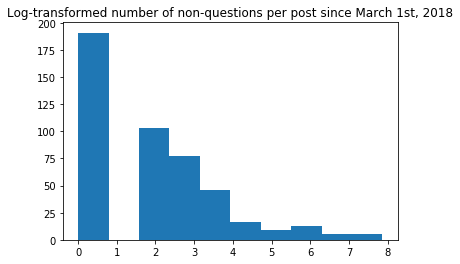

In [38]:
plt.hist([math.log1p(x['non.questions']) for x in all_posts.values()])
plt.title("Log-transformed number of non-questions per post since March 1st, 2018")
plt.show()

## CREATE A STRATIFIED SAMPLE OF AMA GUESTS

In [52]:
def ama_guest():
    return {"author":None,
            "date": None,
            "num.comments":None,
            "num.questions": 0,
            "num.non.questions":0}

ama_guests = defaultdict(ama_guest)

counter = 0
for post_id, post in all_posts.items():
    guest = ama_guest()
    guest['author'] = post['author']
    guest['date'] = post['created']
    guest['num.comments'] = len(post['comments'])
    guest['num.questions'] = post['num.questions']
    guest['num.non.questions'] = post['num.non.questions']
    guest['pct.questions'] = post['num.questions'] / (post['num.questions'] + post['num.non.questions'] + 1 )
    ama_guests[guest['author']]  = guest
    counter += 1
    
print(counter)


465


(array([ 93.,   0.,   0.,   2.,  20.,   5.,  29.,  58., 110., 120.]),
 array([0.        , 0.0999229 , 0.1998458 , 0.2997687 , 0.3996916 ,
        0.49961449, 0.59953739, 0.69946029, 0.79938319, 0.89930609,
        0.99922899]),
 <a list of 10 Patch objects>)

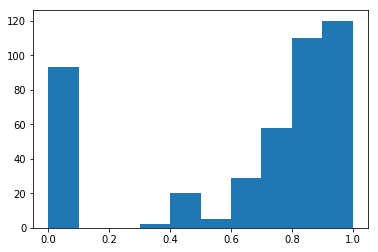

In [54]:
plt.hist([x['pct.questions'] for x in list(ama_guests.values())] )

### Label comments by how many weeks previously the AMA was held (for a stratified random sample)

In [56]:
one_week_in_seconds = 60*60*24*7
current_time = datetime.datetime.utcnow()

for guest_id, guest in ama_guests.items():
    guest['ama.week.diff'] = int((current_time - guest['date']).total_seconds() / 
                                             one_week_in_seconds)
    
    
    

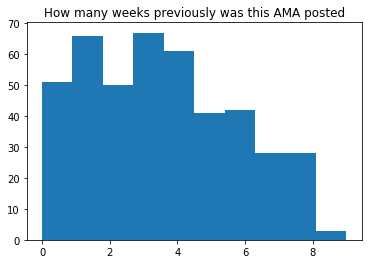

In [59]:
plt.hist([guest['ama.week.diff'] for guest in ama_guests.values()])
plt.title("How many weeks previously was this AMA posted")
plt.show()

### Create a stratified random sample of accounts to message, based on the elapsed number of weeks since they originally posted their AMA
The purpose of this is to get response rates based on how recently they did the AMA. Note that we will want to include them int he sample even if their account doesn't exist, because we're going to be including those kinds of accounts in the study, and we will want to think about that attrition as an expected part of the sample.

In [61]:
eligible_by_week = {}
for key in set([x['ama.week.diff'] for x in ama_guests.values()]):
    eligible_by_week[key] = [x['author'] for x in ama_guests.values() if 
                             x['ama.week.diff'] == key]

In [62]:
for key in sorted(eligible_by_week.keys()):
    print("Week age {0}: {1} authors ".format(key, len(eligible_by_week[key])))

Week age 0: 51 authors 
Week age 1: 66 authors 
Week age 2: 50 authors 
Week age 3: 67 authors 
Week age 4: 61 authors 
Week age 5: 41 authors 
Week age 6: 42 authors 
Week age 7: 28 authors 
Week age 8: 28 authors 
Week age 9: 3 authors 


In [63]:
##  Decision: create a random sample of 40 people per week
##  Only survey the last 6 weeks
random.seed(880442) # current milliseconds at code time
sample_size = 40
selected_by_week = {}
for week in sorted(eligible_by_week.keys()):
    if week <=4:
        selected_by_week[week] = random.sample(eligible_by_week[week], sample_size)
        
for week in sorted(selected_by_week.keys()):
    print("Week age {0}: {1} authors ".format(week, len(selected_by_week[week])))

Week age 0: 40 authors 
Week age 1: 40 authors 
Week age 2: 40 authors 
Week age 3: 40 authors 
Week age 4: 40 authors 


# Construct and personalize the message

# Send the message

False

In [ ]:
#r.send_message('user', 'Subject Line', 'You are awesome!')